In [253]:
import pandas as pd
import os
import datetime as dt

import requests
import json

In [254]:
#crawl historical trading data from trading view of SSI Iboard API
def data_from_tradingview(symbol):
    #API's URL
    trading_view_data_url = 'https://iboard.ssi.com.vn/dchart/api/history'
    #response template
    data_json = {
        'date': [],
        'open': [],
        'high': [],
        'low': [],
        'close': [],
        'volume': [],
    }

    now = dt.datetime.now()
    current_year = now.year
    
    for year in range(2020, current_year+1):
        #config duration of data
        begin_date = int(dt.datetime(year, 1, 1).timestamp())
        end_date = int(dt.datetime(year, 12, 31).timestamp())
        #call API
        response = requests.get(
            f'{trading_view_data_url}?symbol={symbol}&resolution=D&from={begin_date}&to={end_date}')
        response_data = json.loads(response.text)
        data_json['date'].extend(response_data['t'])
        data_json['open'].extend(response_data['o'])
        data_json['high'].extend(response_data['h'])
        data_json['low'].extend(response_data['l'])
        data_json['close'].extend(response_data['c'])
        data_json['volume'].extend(response_data['v'])

    #format response data
    df = pd.DataFrame(data_json)
    df = df.astype('float')
    df['date'] = pd.to_datetime(df['date'], unit='s')
    df = df.set_index('date').sort_index()
    return df


In [255]:
#config symbol(s) that be visualized
symbol_list = ['VND']

historical_data_list = []
for symbol in symbol_list:
    stock_historical_data = data_from_tradingview(symbol)
    historical_data_list.append(stock_historical_data)

historical_data_frame = pd.concat(historical_data_list, axis=1, keys=symbol_list)
historical_data_frame.columns.names = ['Symbol','Stock_Info']

historical_data_frame

Symbol        VND                                 
Stock_Info   open   high    low  close      volume
date                                              
2020-01-02   3.32   3.41   3.32   3.41     58580.0
2020-01-03   3.41   3.41   3.34   3.40    163940.0
2020-01-06   3.35   3.40   3.33   3.38    149130.0
2020-01-07   3.38   3.38   3.33   3.38     68060.0
2020-01-08   3.33   3.34   3.26   3.33    233880.0
...           ...    ...    ...    ...         ...
2022-12-19  16.10  16.90  15.30  15.50  46181200.0
2022-12-20  15.45  15.70  14.60  15.20  40213600.0
2022-12-21  15.50  15.55  14.15  14.65  37810900.0
2022-12-22  14.90  15.00  14.10  14.55  26054800.0
2022-12-23  14.50  14.50  13.90  14.00  20229500.0

[738 rows x 5 columns]

In [256]:
percent_change = pd.DataFrame()
for name in symbol_list:
    percent_change[name] = historical_data_frame[name]['close'].pct_change()
percent_change

,VND
date,
2020-01-02,NaN
2020-01-03,-0.002933
2020-01-06,-0.005882
2020-01-07,0.000000
2020-01-08,-0.014793
...,...
2022-12-19,-0.034268
2022-12-20,-0.019355
2022-12-21,-0.036184


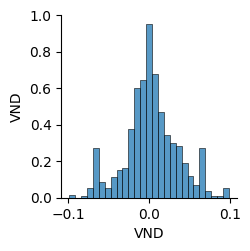

In [257]:
import seaborn as sns
sns.pairplot(percent_change)

<Figure size 1500x500 with 0 Axes>

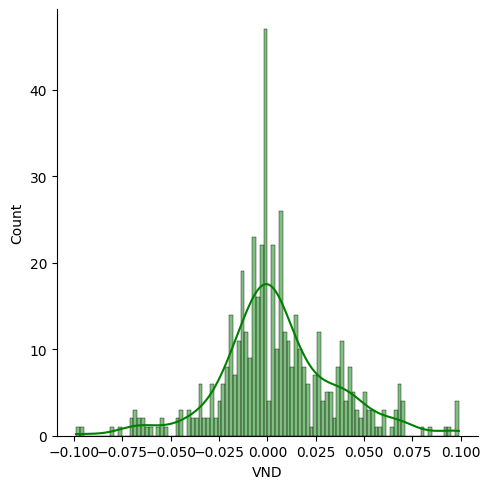

In [258]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))

# thể hiện percent change của giá chứng khoán bằng phân phối chuẩn(sửa tiếng anh dùm nha)
for stock in percent_change.columns:
    sns.displot(percent_change.loc['2020-01-01':'2021-12-31'][stock],color='green',bins=100, kde=True)

In [265]:
import plotly.graph_objects as go
import ta
from plotly.subplots import make_subplots

fig = make_subplots(rows=2 if len(symbol_list) == 1 else 1, cols=1,
                    shared_xaxes=True if len(symbol_list) == 1 else False,
                    vertical_spacing=0.03,
                    row_width=[0.2, 0.7]
                    )

for stock in symbol_list:
    fig.add_trace(go.Scatter(
        x=historical_data_frame[stock].index, y=historical_data_frame[stock]['close'], name=stock, mode='lines'), row=1, col=1)
    if len(symbol_list) == 1:
        # Bar trace for volumes on 2nd row without legend
        fig.add_trace(go.Bar(
            x=historical_data_frame[stock].index, y=historical_data_frame[stock]['volume'], showlegend=False), row=2, col=1)

# Do not show rangeslider plot
fig.update(layout_xaxis_rangeslider_visible=False)

fig.update_layout(
    autosize=False,
    width=780,
    height=540,
)

fig


In [260]:
#compare with VNINDEX
vn_index_symbol = 'VNINDEX'
vn_index_historical_data = data_from_tradingview(vn_index_symbol)


compare_symbol_list = []
compare_symbol_list.extend(symbol_list)
compare_symbol_list.append(vn_index_symbol)


compare_data_list = []
compare_data_list.extend(historical_data_list)
compare_data_list.append(vn_index_historical_data)

compare_data_frame = pd.concat(compare_data_list, axis=1, keys=compare_symbol_list)
compare_data_frame.columns.names = ['Symbol','Historical_Data']
compare_data_frame


Symbol             VND                                   VNINDEX           \
Historical_Data   open   high    low  close      volume     open     high   
date                                                                        
2020-01-02        3.32   3.41   3.32   3.41     58580.0   960.26   966.67   
2020-01-03        3.41   3.41   3.34   3.40    163940.0   968.72   970.88   
2020-01-06        3.35   3.40   3.33   3.38    149130.0   962.79   963.20   
2020-01-07        3.38   3.38   3.33   3.38     68060.0   955.79   959.46   
2020-01-08        3.33   3.34   3.26   3.33    233880.0   954.13   955.84   
...                ...    ...    ...    ...         ...      ...      ...   
2022-12-19       16.10  16.90  15.30  15.50  46181200.0  1053.91  1065.59   
2022-12-20       15.45  15.70  14.60  15.20  40213600.0  1035.82  1038.74   
2022-12-21       15.50  15.55  14.15  14.65  37810900.0  1033.34  1033.84   
2022-12-22       14.90  15.00  14.10  14.55  26054800.0  1026.49  1033.18   
2022-12-23       14.50  14.50  13.90  14.00  20229500.0  1023.69  1027.34   

Symbol                                          
Historical_Data      low    close       volume  
date                                            
2020-01-02        959.67   966.67  200601631.0  
2020-01-03        965.14   965.14  174128840.0  
2020-01-06        955.59   955.79  187204339.0  
2020-01-07        953.19   958.88  181625538.0  
2020-01-08        945.28   948.98  319165887.0  
...                  ...      ...          ...  
2022-12-19       1038.40  1038.40  852324700.0  
2022-12-20       1010.08  1023.13  954038800.0  
2022-12-21       1005.43  1018.88  703570400.0  
2022-12-22       1016.54  1022.61  531712600.0  
2022-12-23       1013.20  1020.34  423823400.0  

[744 rows x 10 columns]

In [261]:
compare_percent_change = pd.DataFrame()
for name in compare_symbol_list:
    compare_percent_change[name] = compare_data_frame[name]['close'].apply(lambda x: (x/(compare_data_frame[name]['close'][0])-1)*100)
compare_percent_change

,VND,VNINDEX
date,,
2020-01-02,0.000000,0.000000
2020-01-03,-0.293255,-0.158275
2020-01-06,-0.879765,-1.125513
2020-01-07,-0.879765,-0.805859
2020-01-08,-2.346041,-1.829994
...,...,...
2022-12-19,354.545455,7.420319
2022-12-20,345.747801,5.840670
2022-12-21,329.618768,5.401016


In [262]:
compare_fig = make_subplots(rows=1, cols=1,
                    shared_xaxes=True,
                    vertical_spacing=0.03)

for stock in compare_symbol_list:
    compare_fig.add_trace(go.Scatter(
        x=compare_percent_change[stock].index, y=compare_percent_change[stock], name=stock, mode='lines'))
    
# Do not show rangeslider plot
compare_fig.update(layout_xaxis_rangeslider_visible=False)

compare_fig.update_layout(
    autosize=False,
    width=780,
    height=540,
)

compare_fig